In [27]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from generate_sample_U import *

In [60]:
def load_model(filename):
    path = f"../gp-models/GPR-models/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, scalers

In [104]:
def generate_placement_sets(n=10000, plot=False):
    '''
    param n : int : the number of placements of interest in set U
    returns : (pd.DataFrame, pd.DataFrame) : tuple of sets in order (S, U)
    '''
    header_list = ["code", "latitude", "longitude"]
    sensor_coords_df = pd.read_csv("../data-collection/LAQN_API_data/site_coordinates.csv", names=header_list)

    S_df = generate_set_S(sensor_coords_df, plot)
    U_df = generate_set_U(sensor_coords_df, n, plot)

    return S_df, U_df

In [115]:
def generate_set_S(sensor_coords_df, plot=False):
    
    ## site placements in original coordinates 
    if plot:
        sensor_coords_df.plot(x="longitude", y="latitude", kind="scatter",
            title="Set S: Sensor Placements")
        plt.show()

    ## site placements in normalized coordinate locations
    # set_S = normalize(coordinates_df=sensor_coords_df)
    # set_S.plot(x="NormalizedX", y="NormalizedY", kind="scatter",
    #     colormap="YlOrRd")
    # plt.show()

    return sensor_coords_df

In [116]:
def generate_set_U(sensor_coords_df, n, plot=False):
    '''
    Given a dataframe of all sensor coordinates and integer n, returns dataframe of n U placements that are 
    uniformly distributed within the London boundaries. These placements do not overlap with sensor coordinates.
    '''
    ## retrieve London coordinate boundaries
    london_burough_boundaries_df = get_london_boundaries()
    london_gdf = geopandas.GeoDataFrame(
        london_burough_boundaries_df, geometry=geopandas.points_from_xy(london_burough_boundaries_df.Longitude, london_burough_boundaries_df.Latitude))
    
    ## find max and min latitude and longitude coordinates, extremes
    min_latitude = math.floor(london_burough_boundaries_df.Latitude.min())
    max_latitude = math.ceil(london_burough_boundaries_df.Latitude.max())
    
    min_longitude = math.floor(london_burough_boundaries_df.Longitude.min())
    max_longitude = math.ceil(london_burough_boundaries_df.Longitude.max())
    
    ## produce equally distributed values of latitude and longitude coordinates within London max and min boundaries
    latitudes = np.linspace(min_latitude, max_latitude, int(n**0.5))
    longitudes =  np.linspace(min_longitude, max_longitude, int(n**0.5))
    u_sites = {'code': [], 'latitude': [], 'longitude': []}
    
    ## creates map_df that contains shapely polygons for each burough
    fp = "../data-collection/london_boroughs.json"
    map_df = geopandas.read_file(fp).to_crs("EPSG:4326")
    map_df = map_df.explode(index_parts=False)

    ## creates U locations with corresponding code
    for i in range(int(n**0.5)):
        for j in range(int(n**0.5)):
            site_code = f"U_{i*j}" # U location code
            num_decimal_places = 13
            float_long = round(float(longitudes[i]), num_decimal_places)
            float_lat = round(float(latitudes[j]), num_decimal_places)
            
            ## creates Point instance of coordinate and a bounding polygon that contains the point
            coord = Point(float_long, float_lat)
            p_range = [-0.00001, 0.0, 0.00001]
            poly_point = Polygon([(coord.x + lam_lat, coord.y + lam_lon) for lam_lat in p_range for lam_lon in p_range])
            
            ## finds whether the bounding coordinate polygon intersects with the burough boundaries
            for burough in map_df.geometry:
                if burough.intersects(poly_point):                   
                    u_sites['code'].append(site_code)
                    u_sites['latitude'].append(latitudes[j])
                    u_sites['longitude'].append(longitudes[i])

    u_sites_df = pd.DataFrame(u_sites)
    
    ## removes current sensor locations from uniformly coordinate placements
    intersection_locations = pd.merge(u_sites_df, sensor_coords_df, how='inner', on=['latitude', 'longitude'])
    set_U = pd.concat([u_sites_df, intersection_locations]).drop_duplicates(keep=False)

    ## plot london boundaries and selected locations of set U
    if plot:
        map_df.plot()
        plt.show()

        set_U.plot(x="longitude", y="latitude", title="Set U", kind="scatter")
        plt.show()

    return set_U

In [117]:
def get_london_boundaries():
    '''
    Returns dataframe of all burough boundaries with columns [latitude, longitude]
    '''
    # if PyShp shapefile library is installed, can read shapefile
    # shape = shapefile.Reader("code/data-collection/London_Borough_Excluding_MHW.shp")

    boundaries = []

    london_burough_boundaries = json.load(open("../data-collection/london_boroughs.json", ))
    for burough in london_burough_boundaries["features"]:
        for coordinate in burough["geometry"]["coordinates"][0][0]:
            boundaries.append(coordinate)
    
    london_burough_boundaries_df = pd.DataFrame(boundaries, columns=['Longitude', 'Latitude'])
    london_burough_boundaries_df = london_burough_boundaries_df[london_burough_boundaries_df.columns[::-1]]

    np_burough_boundaries = london_burough_boundaries_df.to_numpy()
    london_edges = alpha_shape(np_burough_boundaries, 0.25)
    
    # plt.figure()
    # plt.axis('equal')
    # plt.plot(np_burough_boundaries[:, 1], np_burough_boundaries[:, 0], '.')
    # for i, j in london_edges:
    #     plt.plot(np_burough_boundaries[[i, j], 1], np_burough_boundaries[[i, j], 0])
    # plt.show()

    return london_burough_boundaries_df

In [188]:
model_name = "6692_NO2_D_09012011_12312011_False_False_False"
model, df, train_df, test_df, scalers = load_model(model_name)

In [119]:
df_sites = df["code"].unique()

In [120]:
t_max = df['t'].max()
t_max

121

In [121]:
# alex site coordinate data
# sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")

# ana site coordinate data
header_list = ["SiteCode", "Latitude", "Longitude"]
sites_info_df = pd.read_csv("../data-collection/LAQN_API_data/site_coordinates.csv", names=header_list)


In [122]:
sites_info_df.head()

,SiteCode,Latitude,Longitude
0,BX5,51.478802,0.133874
1,BG1,51.563752,0.177891
2,BX1,51.465983,0.184877
3,HS4,51.492507,-0.257252
4,VS1,51.499245,-0.131285


In [123]:
S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})

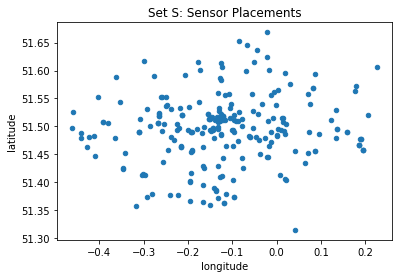

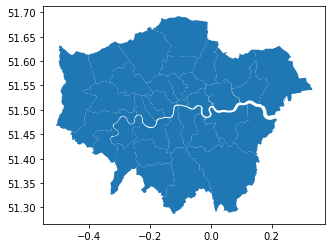

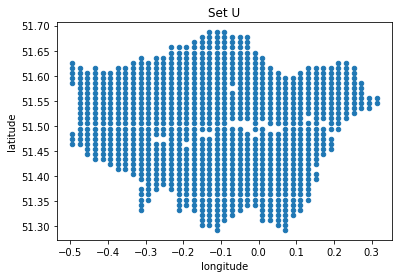

In [124]:
n = 10000
S_df, U_df = generate_placement_sets(n=n, plot=True)

# U_df = U_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})

In [125]:
scalers, S_df.columns, U_df.columns

({'latitude': StandardScaler(), 'longitude': StandardScaler()},
 Index(['code', 'latitude', 'longitude'], dtype='object'),
 Index(['code', 'latitude', 'longitude', 'code_x', 'code_y'], dtype='object'))

In [126]:
for feature in scalers:
    S_df[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)+0.00001*np.random.rand(d, 1)
    U_df[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)+0.00001*np.random.rand(d, 1)

In [127]:
S_df.head()

,code,latitude,longitude,scaled_latitude,scaled_longitude
0,BX5,51.478802,0.133874,-0.432117,1.733068
1,BG1,51.563752,0.177891,1.011796,2.019482
2,BX1,51.465983,0.184877,-0.650006,2.064939
3,HS4,51.492507,-0.257252,-0.199175,-0.811933
4,VS1,51.499245,-0.131285,-0.084647,0.007715


In [128]:
U_df.head()

,code,latitude,longitude,code_x,code_y,scaled_latitude,scaled_longitude
0,U_1150,51.464646,-0.494949,NaN,NaN,-0.672728,-2.358598
1,U_1175,51.474747,-0.494949,NaN,NaN,-0.501039,-2.358598
2,U_1200,51.484848,-0.494949,NaN,NaN,-0.329349,-2.358598
3,U_1450,51.585859,-0.494949,NaN,NaN,1.387548,-2.358598
4,U_1475,51.595960,-0.494949,NaN,NaN,1.559237,-2.358598


In [149]:
"""
Optimize sensor placements using GP model and sets S and U
"""
def krause(GP, k, S_df, U_df, x_features, t_max, t_min=0):
    logs = dict()
    
    A = list()
    A_scores = list()
    for i in range(1, k+1):
        # log_i = []

        y_star_code = None
        delta_y_star = None

        S_diff_A = [site for site in S_df['code'] if site not in A]
        for y in S_diff_A:
            delta_ys = []
            
            for t in range(t_min, t_max+1):
                S_t_df = S_df.copy()
                S_t_df["t"] = t
                U_t_df = U_df.copy()
                U_t_df["t"] = t
                A_t_df = S_t_df.loc[S_t_df['code'].isin(A)]
                
                y_df = S_t_df.loc[S_t_df['code'] == y]
                yA_df = y_df.append(A_t_df)

                yA_mean, yA_cov = GP.predict(yA_df[x_features], return_cov=True)
                
                y_var = np.square(yA_cov[0][0])
                if len(A) == 0:
                    numerator = y_var
                else:
                    yA_cov_row = yA_cov[0, 1:]
                    AA_cov_mat = yA_cov[1:, 1:]
                    numerator = y_var - yA_cov_row@np.linalg.inv(AA_cov_mat)@yA_cov_row.T

                A_y = A + [y]
                S_diff_A_y = [site for site in S_t_df['code'] if site not in A_y]
                A_bar_df = S_t_df.loc[S_t_df['code'].isin(S_diff_A_y)]#.append(U_t_df)
                yA_bar_df = y_df.append(A_bar_df)

                yA_bar_mean, yA_bar_cov = GP.predict(yA_bar_df[x_features], return_cov=True)

                yA_bar_cov_row = yA_bar_cov[0, 1:]
                AA_bar_cov_mat = yA_bar_cov[1:, 1:]
                # print('y_var', y_var)
                # print('AA_bar_cov_mat', AA_bar_cov_mat.shape)
                # print('yA_bar_cov_row', yA_bar_cov_row.shape)
                denominator = y_var - yA_bar_cov_row@np.linalg.inv(AA_bar_cov_mat)@yA_bar_cov_row.T

                delta_y = numerator/denominator
                delta_ys.append(delta_y)
            
            avg_delta_y = np.mean(delta_ys)
                
            if not y_star_code:
                y_star_code = y
                delta_y_star = avg_delta_y
            elif avg_delta_y > delta_y_star:
                y_star_code = y
                delta_y_star = avg_delta_y

        print(yA_cov)
                # log_i.append([y, delta_y])
        A.append(y_star_code)
        A_scores.append(delta_y_star)
        # logs[i] = log_i
        
    A_df = pd.DataFrame({"site": A, "site_score": A_scores, "order": list(range(1, k+1))})
    return A_df, logs

In [ ]:
"""
Optimize sensor placements using GP model and sets S and U

def krause2(GP, k, S_df, U_df, x_features, t_max, t_min=0):
    # logs = dict()
    
    A = list()
    A_scores = list()
    for i in range(1, k+1):
        # log_i = []
        
        A_df = S_df.loc[S_df['code'].isin(A)]
        y_star_code = None
        y_star = None

        S_diff_A = [site for site in S_df['code'] if site not in A]
        for y in S_diff_A:
            for t in range(t_min, t_max+1):
                S_t_df = S_df.copy()
                S_t_df["t"] = t
                U_t_df = U_df.copy()
                U_t_df["t"] = t
                
                y_df = S_df.loc[S_df['code'] == y]
                yA_df = y_df.append(A_df)

                yA_mean, yA_cov = GP.predict(yA_df[x_features], return_cov=True)

                y_var = yA_cov[0][0]
                if len(A) == 0:
                    numerator = y_var
                else:
                    yA_cov_row = yA_cov[0, 1:]
                    AA_cov_mat = yA_cov[1:, 1:]
                    numerator = y_var - yA_cov_row@np.linalg.inv(AA_cov_mat)@yA_cov_row.T

                A_y = A + [y]
                S_diff_A_y = [site for site in S_df['code'] if site not in A_y]
                A_bar_df = S_df.loc[S_df['code'].isin(S_diff_A_y)]#.append(U_df)
                yA_bar_df = y_df.append(A_bar_df)

                yA_bar_mean, yA_bar_cov = GP.predict(yA_bar_df[x_features], return_cov=True)

                yA_bar_cov_row = yA_bar_cov[0, 1:]
                AA_bar_cov_mat = yA_bar_cov[1:, 1:]
                denominator = y_var - yA_bar_cov_row@np.linalg.inv(AA_bar_cov_mat)@yA_bar_cov_row.T

                delta_y = numerator/denominator
                if not y_star_code:
                    y_star_code = y
                    y_star = delta_y
                elif delta_y > y_star:
                    y_star_code = y
                    y_star = delta_y

                # log_i.append([y, delta_y])
        A.append(y_star_code)
        A_scores.append(y_star)
        # logs[i] = log_i
        
    A_df = pd.DataFrame({"site": A, "site_score": A_scores, "order": list(range(1, k+1))})
    return A_df, logs
"""

In [150]:
# add noise to S_df and U_df
S_df_dirty = S_df.copy()
U_df_dirty = U_df.copy()
d_S = S_df.shape[0]
d_U = U_df.shape[0]
for feature in scalers:
    S_df_dirty[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)+0.00001*np.random.rand(d_S, 1)
    U_df_dirty[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)+0.00001*np.random.rand(d_U, 1)

In [151]:
S_df_dirty, S_df

(    code   latitude  longitude  scaled_latitude  scaled_longitude
 0    BX5  51.478802   0.133874        -0.421512          1.727783
 1    BG1  51.563752   0.177891         1.018218          2.014089
 2    BX1  51.465983   0.184877        -0.638768          2.059524
 3    HS4  51.492507  -0.257252        -0.189246         -0.816192
 4    VS1  51.499245  -0.131285        -0.075049          0.003124
 ..   ...        ...        ...              ...               ...
 231  BQ9  51.465983   0.184877        -0.638767          2.059521
 232  IM1  51.517368  -0.120195         0.232095          0.075259
 233  BQ7  51.494649   0.137279        -0.152944          1.749934
 234  EA6  51.530850  -0.292488         0.460590         -1.045380
 235  EA8  51.518948  -0.265617         0.258876         -0.870605
 
 [236 rows x 5 columns],
     code   latitude  longitude  scaled_latitude  scaled_longitude
 0    BX5  51.478802   0.133874        -0.432117          1.733068
 1    BG1  51.563752   0.177891    

In [154]:
A_df_new, logs = krause(GP=model, k=5, S_df=S_df_dirty, U_df=U_df_dirty, x_features=["scaled_latitude", "scaled_longitude", "t"], t_max=1)

[[180.58749425]]
[[1.80587494e+02 1.23450152e-02]
 [1.23450152e-02 2.02243538e+01]]
[[1.80587494e+02 5.50845036e-01 1.23450152e-02]
 [5.50845036e-01 4.95791117e+02 6.03171562e-02]
 [1.23450152e-02 6.03171562e-02 2.02243538e+01]]
[[1.80587494e+02 7.45409505e-01 5.50845036e-01 1.23450152e-02]
 [7.45409505e-01 5.99693297e+02 6.02805027e+00 7.96320471e-02]
 [5.50845036e-01 6.02805027e+00 4.95791117e+02 6.03171562e-02]
 [1.23450152e-02 7.96320471e-02 6.03171562e-02 2.02243538e+01]]
[[1.80587494e+02 7.45409505e-01 5.50845036e-01 8.10503893e-01
  1.23450152e-02]
 [7.45409505e-01 5.99693297e+02 6.02805027e+00 7.93066544e+00
  7.96320471e-02]
 [5.50845036e-01 6.02805027e+00 4.95791117e+02 6.45663440e+00
  6.03171562e-02]
 [8.10503893e-01 7.93066544e+00 6.45663440e+00 6.97828350e+02
  8.72995463e-02]
 [1.23450152e-02 7.96320471e-02 6.03171562e-02 8.72995463e-02
  2.02243538e+01]]


In [42]:
A_df

,site,site_score,order
0,ST6,1.038264,1
1,ST9,1.028588,2
2,CR9,1.025953,3
3,EN5,1.023070,4
4,HR2,1.016532,5


In [155]:
A_df_new

,site,site_score,order
0,KC7,1.032824,1
1,BX9,1.004165,2
2,EA0,1.003503,3
3,MY7,1.002092,4
4,BQ7,1.001600,5


In [182]:
def plot_krause_df(A, S_df, U_df):
    cols = ["code", "latitude", "longitude", "Status", "k"]
    df = pd.DataFrame(columns=cols)
    k = len(A)
    for i in range(1, k+1):
        chosen_sites = A.site
        print(chosen_sites)
        df_i = S_df.copy()
        df_i["Status"] = "Not chosen"
        df_i["k"] = i
        for a in chosen_sites:
            print("chosen site ", a)
            df_i.loc[df_i["code"] == a, "Status"] = "Chosen"
        df = df.append(df_i)
        
    U_copy = U_df.copy()
    U_copy["Status"] = "U"
    U_copy["k"] = 0
    df = df.append(U_copy)
    return df

In [183]:
plot_df = plot_krause_df(A_df_new, S_df, U_df)

0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7


In [184]:
plot_df

,code,latitude,longitude,Status,k,scaled_latitude,scaled_longitude,code_x,code_y
0,BX5,51.478802,0.133874,Not chosen,1,-0.432117,1.733068,NaN,NaN
1,BG1,51.563752,0.177891,Not chosen,1,1.011796,2.019482,NaN,NaN
2,BX1,51.465983,0.184877,Not chosen,1,-0.650006,2.064939,NaN,NaN
3,HS4,51.492507,-0.257252,Not chosen,1,-0.199175,-0.811933,NaN,NaN
4,VS1,51.499245,-0.131285,Not chosen,1,-0.084647,0.007715,NaN,NaN
...,...,...,...,...,...,...,...,...,...
985,U_3392,51.535354,0.292929,U,0,0.529099,2.768020,NaN,NaN
986,U_3456,51.545455,0.292929,U,0,0.700789,2.768020,NaN,NaN
987,U_3520,51.555556,0.292929,U,0,0.872479,2.768020,NaN,NaN
988,U_3510,51.545455,0.313131,U,0,0.700789,2.899472,NaN,NaN


In [212]:
import plotly.express as px
import geopandas as gpd

In [218]:
london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
london_wards = london_wards.to_crs("EPSG:4326")
london_wards.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


In [217]:
fig = px.scatter_mapbox(plot_df,
lat='latitude',
lon='longitude', 
color="Status",
#animation_frame="k",
#animation_group="SiteCode",
width=1000, 
height=600,
zoom=10,
text="code"
)
px.line_mapbox(london_wards, lat=london_wards)

fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))
fig.update_layout(mapbox_style="carto-positron", margin = dict(l = 0, r = 0, t = 10, b = 0))

fig.show(renderer="notebook")

KeyError: None

<AxesSubplot:>

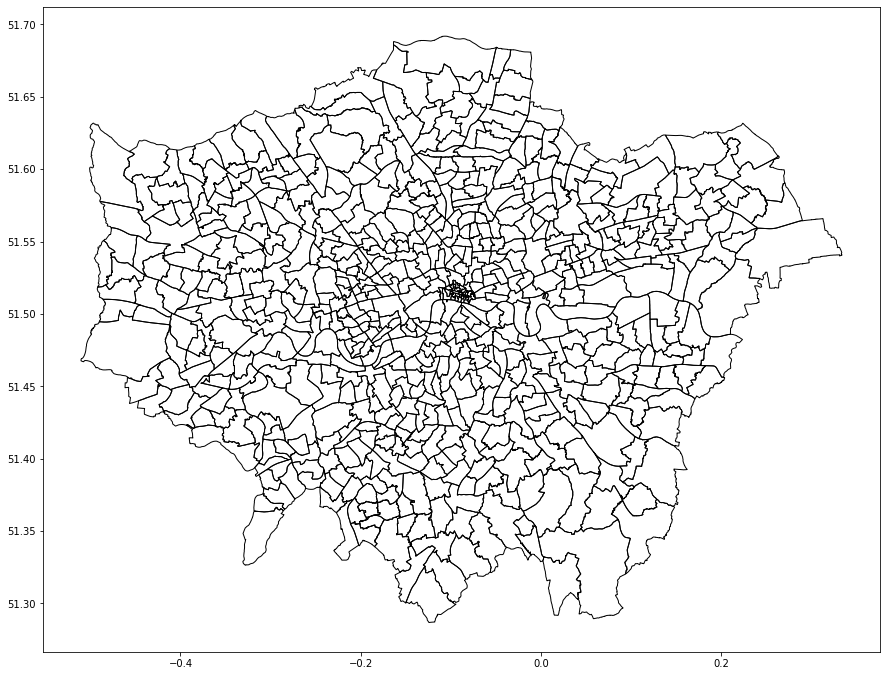

In [213]:
london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
london_wards = london_wards.to_crs("EPSG:4326")
london_wards.head()

fig, ax = plt.subplots(figsize=(15,15))
ax.set_facecolor('white')
london_wards.plot(ax=ax, color="None")

In [235]:
import folium
import datetime

def save_folium_map(data_df, pollutant, layer_title, date_today, mapping_directory):
    '''
    Save map to interactive html map file using the Folium library.
    
    :param: data_df: dataframe including the training / validation datasets for the gp model

    '''
    
    # import London burough shapefile as geopandas dataframe
    london_gdf = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
    print(london_gdf.head())
    
    # create folium map of buroughs
    london_center = [51.507602, -0.127816]
    m = folium.Map(location=london_center, zoom_start=10)

    london_gdf.explore(
        m=m,
        column="NAME", # make choropleth based on "BoroName" column
        color="grey",
        tooltip="NAME", # show "BoroName" value in tooltip (on hover)
        popup=True, # show all values in popup (on click)
        tiles="CartoDB positron", # use "CartoDB positron" tiles
        cmap="Set1", # use "Set1" matplotlib colormap
        legend=False, # show legend on the map
        style_kwds=dict(color="black", weight=3, opacity=0.2) # use black outline
    )

    # convert data points df to geopandas dataframe
    U_df = data_df.loc[data_df.Status=='U']
    print(U_df)
    chosen_df = data_df.loc[data_df.Status=='Chosen']
    unchosen_df = data_df.loc[data_df.Status=='Not chosen']

    U_geodf = gpd.GeoDataFrame(
        U_df, geometry=gpd.points_from_xy(U_df.longitude, U_df.latitude), crs="EPSG:4326")
    print(U_geodf)
    chosen_geodf = gpd.GeoDataFrame(
        chosen_df, geometry=gpd.points_from_xy(chosen_df.longitude, chosen_df.latitude))
    unchosen_geodf = gpd.GeoDataFrame(
        unchosen_df, geometry=gpd.points_from_xy(unchosen_df.longitude, unchosen_df.latitude))
    
    # add geodataframe of data to folium map
    geo_dfs = [U_geodf, chosen_geodf, unchosen_geodf]
    status = ['U', 'Chosen', 'Not Chosen']
    colors = ['']
    for i in range(len(geo_dfs)):
        geo_df = geo_dfs[i]
        geo_df.explore(
            m=m, # pass the map object
            marker_kwds=dict(radius=3, fill=True), # make marker radius 10px with fill
            # column=pollutant, # make choropleth based on {pollutant} column
            popup=True,
            tooltip=["code"], # show "name" column in the tooltip
            tooltip_kwds=dict(labels=True), # do not show column label in the tooltip
            name=status[i], # name of the layer in the map 
            legend_kwds={'label': pollutant + " Concentration",
                            'orientation': "horizontal"},
            legend=True,
        )

    # add base map features
    # folium.TileLayer("CartoDB", control=True).add_to(m)  # use folium to add alternative tiles
    
    folium.TileLayer('cartodbdark_matter', attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>').add_to(m)
    folium.TileLayer('cartodbpositron', attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>').add_to(m)
    # folium.TileLayer('MapQuest Open Aerial').add_to(m)
    # folium.TileLayer('mapquestopen').add_to(m)
    folium.LayerControl().add_to(m)  # use folium to add layer control

    # Save map to mapping directory
    # as HTML file
    map_name = layer_title + ","+ date_today
    print("Saving map to: ", map_name)
    m.save(mapping_directory + map_name + ".html")

In [236]:
save_path = f"../gp-models/GPR_figures/{model_name}/"
map_title = "London Burough Map Training Points"
save_folium_map(plot_df, pollutant='N02', layer_title=map_title, date_today=datetime.datetime.now().strftime("%m-%d-%Y,%H:%M:%S"), mapping_directory=save_path)
    

                     NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
1  POLYGON ((517829.600 165447.100, 517837.100 16...  
2  POLYGON ((518107.500 167303.400, 518114.300 16...  
3  POLYGON ((520480.000 166909.800, 520490.700 16...  
4  POLYGON ((522071.000 168144.900, 522063.900 16...  
       code   

In [25]:
A_df_new

,site,site_score,order
0,EN1,1.009986,1
1,LB6,1.009424,2
2,GR7,1.008785,3
3,EN7,1.008540,4
4,TH4,1.008030,5


In [23]:
A_df_new, logs = krause(model, 5, S_df, U_df, ["scaled_latitude", "scaled_longitude", "t"], 0)

In [30]:
A_df_new_2, logs = krause(model, 5, S_df, U_df, ["scaled_latitude", "scaled_longitude", "t"], 0)

[[2.6900533e-08]]
[[2.69009511e-08 8.95983576e-14]
 [8.95983576e-14 2.69008914e-08]]
[[2.69009511e-08 8.95983576e-14 0.00000000e+00]
 [8.95983576e-14 2.69008914e-08 2.98661192e-14]
 [0.00000000e+00 2.98661192e-14 2.69011303e-08]]
[[ 2.69009511e-08  8.95983576e-14 -2.98661192e-14  0.00000000e+00]
 [ 8.95983576e-14  2.69008914e-08 -8.95983576e-14  2.98661192e-14]
 [-2.98661192e-14 -8.95983576e-14  2.69012498e-08  2.98661192e-14]
 [ 0.00000000e+00  2.98661192e-14  2.98661192e-14  2.69011303e-08]]
[[ 2.69009511e-08  8.95983576e-14 -2.98661192e-14 -2.98661192e-14
   0.00000000e+00]
 [ 8.95983576e-14  2.69008914e-08  0.00000000e+00 -8.95983576e-14
   2.98661192e-14]
 [-2.98661192e-14  0.00000000e+00  2.69010109e-08 -2.98661192e-14
  -2.98661192e-14]
 [-2.98661192e-14 -8.95983576e-14 -2.98661192e-14  2.69012498e-08
   2.98661192e-14]
 [ 0.00000000e+00  2.98661192e-14 -2.98661192e-14  2.98661192e-14
   2.69011303e-08]]


In [31]:
A_df_new_2

,site,site_score,order
0,EN1,1.009986,1
1,LB6,1.009424,2
2,GR7,1.008785,3
3,EN7,1.008540,4
4,TH4,1.008030,5
